# Notebook to create a Drug-Disease Matrix including all OPRM1-interacting drugs

## Obtain eids and start and end era per drug

Using omop drug era database

In [1]:
import pyspark
import dxpy
import dxdata
from pyspark.sql import functions as F

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Import to current directory:
- mappings/drug_era/drug_era_atc.tsv
- src/project_permed

First obtain the drug id with drug_era_atc.tsv table and the atc_dict.py to obtain the ATC of each drug.

In [ ]:
# Load the table
df_ATC = pd.read_csv("drug_era_atc.tsv", sep="\t")

# Convert concept_name and drugs_to_filter to lowercase for case-insensitive filtering
df_ATC["concept_name_lower"] = df_ATC["concept_name"].str.lower()

# List of drugs to filter
drugs_to_filter = [
    "Loperamide",
    "Morphine",
    "Methadone",
    "Fentanyl",
    "Sufentanil",
    "3-Methylfentanyl",
    "3-Methylthiofentanyl",
    "Alfentanil",
    "Alvimopan",
    "Amisulpride",
    "Amitriptyline",
    "Anileridine",
    "Aripiprazole",
    "Buprenorphine",
    "Butorphanol",
    "Butyrfentanyl",
    "Cannabidiol",
    "Carfentanil",
    "Codeine",
    "Dextromethorphan",
    "Dextropropoxyphene",
    "Dezocine",
    "Diamorphine",
    "Dihydromorphine",
    "Dimethylthiambutene",
    "Diphenoxylate",
    "Diprenorphine",
    "Eluxadoline",
    "Epicept Np-1",
    "Ethylmorphine",
    "Etorphine",
    "Hydrocodone",
    "Hydromorphone",
    "Ketamine",
    "Ketobemidone",
    "Li-301",
    "Levacetylmethadol",
    "Levallorphan",
    "Levorphanol",
    "Loxicodegol",
    "Cannabis",
    "Meperidine",
    "Metenkefalin",
    "Methadyl Acetate",
    "Methylnaltrexone",
    "Morphine Glucuronide",
    "Nabiximols",
    "Nalbuphine",
    "Naldemedine",
    "Nalmefene",
    "Naloxegol",
    "Naloxone",
    "Naltrexone",
    "Oliceridine",
    "Ondansetron",
    "Opium",
    "Oxycodone",
    "Oxymorphone",
    "Pentazocine",
    "Pentoxyverine",
    "Pholcodine",
    "Remifentanil",
    "Samidorphan",
    "Tapentadol",
    "Tianeptine",
    "Tramadol",
    "Trimebutine",
    "V1003",
]
drugs_to_filter_lower = {drug.lower() for drug in drugs_to_filter}

# Filter rows where the lowercase drug name is in the lowercase list of drugs to filter
filtered_df_ATC = df_ATC[df_ATC["concept_name"].isin(drugs_to_filter_lower)]

# Identify drugs that do not appear in the dataframe
missing_drugs = drugs_to_filter_lower - set(df_ATC["concept_name_lower"])

# Print a message if there are missing drugs
if missing_drugs:
    print(
        f"The following drugs were not found in the dataset: {', '.join(missing_drugs)}"
    )

# Drop the temporary lowercase column to keep the original dataframe clean
df_ATC.drop(columns=["concept_name_lower"], inplace=True)

# Select the required columns and rename _c13 to ATC
filtered_df_ATC = filtered_df_ATC[
    [
        "drug_concept_id",
        "concept_name",
        "domain_id",
        "concept_class_id",
        "concept_code",
        "valid_start_date",
        "valid_end_date",
        "invalid_reason",
        "_c13",
    ]
]

# Rename the _c13 column to ATC
filtered_df_ATC.rename(columns={"_c13": "ATC"}, inplace=True)

display(filtered_df_ATC)

In [ ]:
# Import the ATC dictionaries from atc_dict.py
from atc_dict import atc_1st_level, atc_2nd_level

# Map first level ATC codes
filtered_df_ATC["ATC_First_Level"] = filtered_df_ATC["ATC"].apply(
    lambda x: x[0] if isinstance(x, str) else None
)
filtered_df_ATC["ATC_Second_Level"] = filtered_df_ATC["ATC"].apply(
    lambda x: x[:3] if isinstance(x, str) else None
)

# Map the names of the first and second level ATC categories using the imported dictionaries
filtered_df_ATC["First_Level_Name"] = filtered_df_ATC["ATC_First_Level"].map(
    atc_1st_level
)
filtered_df_ATC["Second_Level_Name"] = filtered_df_ATC["ATC_Second_Level"].map(
    lambda x: atc_2nd_level.get(x[0], {}).get(x, "Unknown")
)

filtered_df_ATC

In [ ]:
# Save the filtered table to a new file
filtered_df_ATC.to_csv("filtered_drug_atc.tsv", sep="\t", index=False)

Now we can obtain the omop data bases from UK Biobank and filter for the drugs ids of interest

In [ ]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

dispensed_database_name = dxpy.find_one_data_object(
    classname="database", name="app*", folder="/", name_mode="glob", describe=True
)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(
    typename="Dataset", name="app*.dataset", folder="/", name_mode="glob"
)["id"]

spark.sql("USE " + dispensed_database_name)

dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [ ]:
# Init pyspark and load dataframe
# Load the 'omop_drug_era' table
omop_drug_era = "omop_drug_era"

# Load table
drug_era = dataset[omop_drug_era]

# Extract all field names from the table
field_names_era = [f.name for f in drug_era.fields]

# Retrieve the fields
df_era = drug_era.retrieve_fields(names=field_names_era, engine=dxdata.connect())

print(df_era.columns)

print(f"Number of entries era {df_era.count()}")
df_era.drop("eid").show(3, truncate=False)

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


['eid', 'drug_era_id', 'drug_concept_id', 'drug_era_start_date', 'drug_era_end_date', 'drug_exposure_count', 'gap_days']
Number of entries era 19959413
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|1236950609195|19005129       |12/05/2014         |10/06/2014       |1                  |0       |
|798863919105 |743670         |30/03/2011         |02/09/2011       |5                  |12      |
|721554547993 |19008994       |12/10/2010         |07/11/2010       |1                  |0       |
+-------------+---------------+-------------------+-----------------+-------------------+--------+
only showing top 3 rows



In [ ]:
# Load the `filtered_drug_atc.tsv` file as a Pandas DataFrame
drug_mapping_df = pd.read_csv("filtered_drug_atc.tsv", sep="\t")
# Extract `drug_concept_id` values as a list
drug_concept_ids = drug_mapping_df["drug_concept_id"].dropna().unique().tolist()
drug_concept_ids

[930916,
 1154029,
 1102527,
 1103640,
 757688,
 45774613,
 710062,
 785649,
 991876,
 1714319,
 1000560,
 19014158,
 19024213,
 19026459,
 1133201,
 1103314,
 19057607,
 19059528,
 1114220,
 1130585,
 1510417,
 1201620,
 1119510,
 1126658,
 1110410,
 1124957]

In [ ]:
# Filter the OMOP dataset for relevant drug_concept_id
filtered_df_era = df_era.filter(F.col("drug_concept_id").isin(drug_concept_ids))
# Format date columns
filtered_df_era = filtered_df_era.withColumn(
    "drug_era_start_date", F.to_date(F.col("drug_era_start_date"), "dd/MM/yyyy")
).withColumn("drug_era_end_date", F.to_date(F.col("drug_era_end_date"), "dd/MM/yyyy"))

# Show the result of the filter
filtered_df_era.drop("eid").show(truncate=False)
filtered_df_era.count()

+-------------+---------------+-------------------+-----------------+-------------------+--------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|523986031867 |1201620        |2005-01-04         |2005-02-02       |1                  |0       |
|1194000909628|1133201        |1993-08-20         |1993-10-26       |2                  |9       |
|704374697810 |1201620        |2008-07-29         |2008-10-17       |2                  |22      |
|68719563134  |710062         |1996-11-11         |1996-11-20       |1                  |0       |
|1236950640019|710062         |2010-07-20         |2010-07-29       |1                  |0       |
|575525667834 |1201620        |2015-05-28         |2015-06-26       |1                  |0       |
|781684097755 |1201620        |2009-12-24         |2010-01-07       |1                  |0       |
|300647715

869262

In [ ]:
# Convert the filtered Spark DataFrame to a Pandas DataFrame
pandas_df_era = filtered_df_era.toPandas()
pandas_df_era.loc[:, "drug_concept_id"] = pandas_df_era.loc[
    :, "drug_concept_id"
].astype(int)
# Merge pandas_df_era with drug_mapping_df on `drug_concept_id`
pandas_df_era = pandas_df_era.merge(
    drug_mapping_df[["drug_concept_id", "concept_name"]],  # Only keep necessary columns
    on="drug_concept_id",
    how="left",
)
# Rename the 'concept_name' column to 'drug'
pandas_df_era.rename(columns={"concept_name": "drug"}, inplace=True)
pandas_df_era = pandas_df_era.sort_values(by="drug_era_start_date")

# Save the Pandas DataFrame to a CSV file
pandas_df_era.to_csv("filtered_data_era.csv", index=False)

In [ ]:
display(pandas_df_era.drop("eid", axis=1))

,drug_era_id,drug_concept_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,drug
369798,1486058743225,991876,1990-01-01,1990-01-06,1,0,loperamide
26201,652835088928,991876,1990-01-01,1990-01-30,1,0,loperamide
717479,1597727924666,1201620,1990-01-01,1990-01-30,1,0,codeine
715027,1314260071294,991876,1990-01-01,1990-01-12,1,0,loperamide
781916,601295454371,1201620,1990-01-02,1990-01-31,1,0,codeine
...,...,...,...,...,...,...,...
543194,1090921769373,710062,2017-09-27,2017-10-04,1,0,amitriptyline
824085,1348619825917,991876,2017-10-16,2017-10-27,1,0,loperamide
428602,506806163345,710062,2017-11-20,2017-11-27,1,0,amitriptyline
428704,1649267483604,710062,2018-01-15,2018-01-22,1,0,amitriptyline


## Obtain eids and diagnosis start day per disease

In [ ]:
# Load the 'Date of first in-patient diagnosis - ICD10' table
hesin_diag = dataset["hesin_diag"]
hesin = dataset["hesin"]

# Extract all field names from the table
field_names_hesin_diag = [f.name for f in hesin_diag.fields]
field_names_hesin = [f.name for f in hesin.fields]

# Retrieve the fields
diagnosis_df = hesin_diag.retrieve_fields(
    names=field_names_hesin_diag, engine=dxdata.connect()
)
hesin_df = hesin.retrieve_fields(names=field_names_hesin, engine=dxdata.connect())

print(diagnosis_df.columns)
print(hesin_df.columns)

# Filter the HESIN_DIAG table to include only the EIDs in pandas_df_era
eid_list = pandas_df_era["eid"].unique().tolist()
filtered_diagnosis_df = diagnosis_df.filter(diagnosis_df["eid"].isin(eid_list))

print(f"Number of entries era {filtered_diagnosis_df.count()}")
filtered_diagnosis_df.drop("eid").show(3, truncate=False)

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


['dnx_hesin_diag_id', 'dnx_hesin_id', 'eid', 'ins_index', 'arr_index', 'level', 'diag_icd9', 'diag_icd9_nb', 'diag_icd10', 'diag_icd10_nb']
['dnx_hesin_id', 'eid', 'ins_index', 'epiorder', 'spell_index', 'spell_seq', 'spelbgin', 'spelend', 'speldur', 'pctcode', 'gpprpct', 'category', 'elecdate', 'dsource', 'elecdur', 'admidate', 'admimeth_uni', 'admimeth', 'admisorc_uni', 'admisorc', 'firstreg', 'classpat_uni', 'classpat', 'intmanag_uni', 'source', 'intmanag', 'mainspef_uni', 'mainspef', 'tretspef_uni', 'tretspef', 'operstat', 'disdate', 'dismeth_uni', 'dismeth', 'disdest_uni', 'epistart', 'disdest', 'carersi', 'epiend', 'epidur', 'bedyear', 'epistat', 'epitype']
Number of entries era 5657825
+-----------------+------------+---------+---------+-----+---------+------------+----------+-------------+
|dnx_hesin_diag_id|dnx_hesin_id|ins_index|arr_index|level|diag_icd9|diag_icd9_nb|diag_icd10|diag_icd10_nb|
+-----------------+------------+---------+---------+-----+---------+------------+---

In [ ]:
# Perform a left join to keep only rows from filtered_diagnosis_df and add epistart from hesin_df
filtered_diagnosis_df = filtered_diagnosis_df.join(
    hesin_df.select("eid", "ins_index", "epistart"),  # Selecting only necessary columns
    on=["eid", "ins_index"],
    how="left",
)

print(f"Number of entries era {filtered_diagnosis_df.count()}")
filtered_diagnosis_df.drop("eid").show(3, truncate=False)

Number of entries era 5657825
+---------+-----------------+------------+---------+-----+---------+------------+----------+-------------+----------+
|ins_index|dnx_hesin_diag_id|dnx_hesin_id|arr_index|level|diag_icd9|diag_icd9_nb|diag_icd10|diag_icd10_nb|epistart  |
+---------+-----------------+------------+---------+-----+---------+------------+----------+-------------+----------+
|42       |1273199-42-1     |1273199-42  |1        |2    |NULL     |NULL        |M059      |NULL         |2019-03-01|
|4        |1898529-4-2      |1898529-4   |2        |2    |NULL     |NULL        |Z901      |NULL         |2010-05-04|
|27       |1144086-27-3     |1144086-27  |3        |2    |NULL     |NULL        |I209      |NULL         |2017-11-02|
+---------+-----------------+------------+---------+-----+---------+------------+----------+-------------+----------+
only showing top 3 rows



In [ ]:
# Select only the required columns
final_diagnosis_df = filtered_diagnosis_df.select(
    "eid", "ins_index", "arr_index", "diag_icd10", "epistart"
)
# Format date columns
final_diagnosis_df = final_diagnosis_df.withColumn(
    "epistart", F.to_date(F.col("epistart"), "dd/MM/yyyy")
)

# Show the results
final_diagnosis_df.drop("eid").show(3, truncate=False)
print(f"Number of entries era {final_diagnosis_df.count()}")

+---------+---------+----------+----------+
|ins_index|arr_index|diag_icd10|epistart  |
+---------+---------+----------+----------+
|42       |1        |M059      |2019-03-01|
|4        |2        |Z901      |2010-05-04|
|27       |3        |I209      |2017-11-02|
+---------+---------+----------+----------+
only showing top 3 rows

Number of entries era 5657825


In [ ]:
final_diagnosis_df = final_diagnosis_df.dropDuplicates(
    ["eid", "diag_icd10", "epistart"]
)

final_diagnosis_df.drop("eid").show(truncate=False)
print(f"Number of entries after removing duplicates: {final_diagnosis_df.count()}")

+---------+---------+----------+----------+
|ins_index|arr_index|diag_icd10|epistart  |
+---------+---------+----------+----------+
|3        |2        |Z824      |2014-10-08|
|19       |2        |I709      |2022-01-27|
|20       |7        |N19       |2019-04-18|
|47       |0        |C829      |2018-04-23|
|18       |8        |M199      |2018-09-27|
|54       |7        |I679      |2021-08-11|
|2        |1        |I10       |2019-06-16|
|29       |0        |K429      |2006-03-03|
|8        |0        |H402      |2012-01-06|
|12       |8        |F329      |2021-11-10|
|6        |18       |M4780     |2020-03-04|
|6        |1        |E780      |2016-08-02|
|8        |0        |R195      |2019-03-07|
|29       |1        |E114      |2009-09-23|
|42       |0        |N47       |2017-08-21|
|18       |4        |C788      |2011-11-04|
|40       |7        |Z907      |2018-08-10|
|60       |18       |Z926      |2022-02-12|
|15       |3        |I259      |2014-01-26|
|26       |0        |R194      |

## Now join the drug_era and diagnosis tables and filter the diagnosis base on dates
We want to keep the diagonsis that start in the middle of a drug era or maximum of 30 days before

In [ ]:
# Perform a join on "eid" with the drug era df
joined_df_era_diagnosis = filtered_df_era.join(
    final_diagnosis_df.select(
        "eid", "diag_icd10", "epistart"
    ),  # Selecting only necessary columns
    on="eid",
    how="left",
)

# Show the final DataFrame
joined_df_era_diagnosis.drop("eid").show(truncate=False)
print(f"Number of entries era {joined_df_era_diagnosis.count()}")

+------------+---------------+-------------------+-----------------+-------------------+--------+----------+----------+
|drug_era_id |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|diag_icd10|epistart  |
+------------+---------------+-------------------+-----------------+-------------------+--------+----------+----------+
|944892806470|1201620        |2010-05-21         |2010-06-19       |1                  |0       |Z854      |2015-10-28|
|944892806470|1201620        |2010-05-21         |2010-06-19       |1                  |0       |W182      |2019-11-11|
|944892806470|1201620        |2010-05-21         |2010-06-19       |1                  |0       |K627      |2015-11-10|
|944892806470|1201620        |2010-05-21         |2010-06-19       |1                  |0       |M480      |2021-07-23|
|944892806470|1201620        |2010-05-21         |2010-06-19       |1                  |0       |Z854      |2015-11-10|
|944892806470|1201620        |2010-05-21

In [ ]:
# Filter where diagnosis_date is within (drug_era_start_date - 1 month) and (drug_era_end_date)
filtered_df_era_diagnosis = joined_df_era_diagnosis.filter(
    (
        F.col("epistart") >= F.date_sub(F.col("drug_era_start_date"), 30)
    )  # Up to 1 month before start date
    & (F.col("epistart") <= F.col("drug_era_end_date"))  # Within drug era
)
filtered_df_era_diagnosis.drop("eid").show(truncate=False)
print(f"Number of entries era {filtered_df_era_diagnosis.count()}")

+-------------+---------------+-------------------+-----------------+-------------------+--------+----------+----------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|diag_icd10|epistart  |
+-------------+---------------+-------------------+-----------------+-------------------+--------+----------+----------+
|1116691570675|1201620        |2014-09-04         |2014-10-25       |2                  |0       |E780      |2014-09-11|
|1116691570675|1201620        |2014-09-04         |2014-10-25       |2                  |0       |M169      |2014-09-11|
|429496730275 |1201620        |2012-07-02         |2017-05-31       |66                 |884     |K449      |2014-11-26|
|429496730275 |1201620        |2012-07-02         |2017-05-31       |66                 |884     |I10       |2014-11-26|
|429496730275 |1201620        |2012-07-02         |2017-05-31       |66                 |884     |K573      |2014-11-26|
|429496730275 |1201620        |2

In [ ]:
# Group by 'eid' and 'drug_concept_id', and collect unique values for the other columns
grouped_df_era_diagnosis = filtered_df_era_diagnosis.groupBy(
    "eid", "drug_concept_id"
).agg(
    F.countDistinct("drug_era_id").alias(
        "unique_drug_era_count"
    ),  # Count of unique drug_era_ids
    F.collect_set("drug_era_start_date").alias(
        "drug_era_start_dates"
    ),  # Unique start dates
    F.collect_set("drug_era_end_date").alias("drug_era_end_dates"),  # Unique end dates
    F.collect_list("diag_icd10").alias(
        "diag_icd10"
    ),  # Collect diag_icd10 without removing duplicates
    F.collect_list("epistart").alias("epistarts"),  # Collect epistart
)

# Show the new DataFrame
grouped_df_era_diagnosis.drop("eid").show(3, truncate=False)
print(f"Number of entries era {grouped_df_era_diagnosis.count()}")

+---------------+---------------------+------------------------+------------------------+----------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------+
|drug_concept_id|unique_drug_era_count|drug_era_start_dates    |drug_era_end_dates      |diag_icd10                                                      |epistarts                                                                                                                           |
+---------------+---------------------+------------------------+------------------------+----------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------+
|1201620        |1                    |[2014-09-04]            |[2014-10-25]            |[E780, M169]                                   

In [ ]:
# Convert the filtered Spark DataFrame to a Pandas DataFrame
pandas_grouped_df_era_diagnosis = grouped_df_era_diagnosis.toPandas()
pandas_grouped_df_era_diagnosis.loc[:, "drug_concept_id"] = (
    pandas_grouped_df_era_diagnosis.loc[:, "drug_concept_id"].astype(int)
)
# Remove duplicates in drug_mapping_df based on 'drug_concept_id' and 'concept_name'
drug_mapping_df = drug_mapping_df.drop_duplicates(
    subset=["drug_concept_id", "concept_name"]
)
# Merge pandas_df_era with drug_mapping_df on `drug_concept_id`
pandas_grouped_df_era_diagnosis = pandas_grouped_df_era_diagnosis.merge(
    drug_mapping_df[["drug_concept_id", "concept_name"]],  # Only keep necessary columns
    on="drug_concept_id",
    how="left",
)
# Rename the 'concept_name' column to 'drug'
pandas_grouped_df_era_diagnosis.rename(columns={"concept_name": "drug"}, inplace=True)

# Save the Pandas DataFrame to a CSV file
pandas_grouped_df_era_diagnosis.to_csv("grouped_df_era_diagnosis.csv", index=False)

In [ ]:
pandas_grouped_df_era_diagnosis.drop("eid", axis=1)

,drug_concept_id,unique_drug_era_count,drug_era_start_dates,drug_era_end_dates,diag_icd10,epistarts,drug
0,1201620,1,[2014-09-04],[2014-10-25],"[E780, M169]","[2014-09-11, 2014-09-11]",codeine
1,1201620,1,[2012-07-02],[2017-05-31],"[K449, I10, K573, D508]","[2014-11-26, 2014-11-26, 2014-11-26, 2014-11-26]",codeine
2,1201620,2,"[2014-07-22, 2014-04-17]","[2014-08-20, 2014-05-30]","[I251, E780, I200, Z955, I10, I209, K358, I10,...","[2014-05-07, 2014-05-07, 2014-05-07, 2014-05-0...",codeine
3,1103314,1,[2011-08-23],[2011-09-01],[R074],[2011-08-10],tramadol
4,1201620,1,[2011-08-08],[2011-10-29],"[H409, M1395, Z835, Z867, R074, H251]","[2011-09-06, 2011-09-06, 2011-09-06, 2011-09-0...",codeine
...,...,...,...,...,...,...,...
69104,1103314,3,"[2013-06-21, 2010-04-27, 2013-04-02]","[2011-06-23, 2014-01-30, 2013-05-17]","[K449, K227, E119, K221, M548, N40, K297, E119...","[2013-03-04, 2013-03-04, 2011-06-05, 2010-05-2...",tramadol
69105,1133201,1,[2010-12-10],[2016-07-05],"[Z951, E119, N47, K227, E119, N47, M548, K449,...","[2014-11-26, 2014-11-26, 2014-11-26, 2014-12-0...",buprenorphine
69106,1201620,1,[2009-06-29],[2009-08-19],"[I209, I251, R074]","[2009-06-22, 2009-06-22, 2009-06-19]",codeine
69107,1201620,2,"[2014-03-20, 2015-05-29]","[2015-09-16, 2014-08-12]","[K219, N328, K449, H729, Z864, J348, M754, K44...","[2014-02-19, 2014-02-19, 2014-02-19, 2014-04-1...",codeine


## Add diseases based on icd10 codes

In [ ]:
# Function to transform ICD-10 codes to level 1 format
def transform_icd10(icd10_list):
    return list(
        set(code[:3] for code in icd10_list)
    )  # Extract first letter + 2 numbers and remove duplicates


# Apply the transformation to create the new column
pandas_grouped_df_era_diagnosis["diag_icd10_level1"] = pandas_grouped_df_era_diagnosis[
    "diag_icd10"
].apply(transform_icd10)
pandas_grouped_df_era_diagnosis.drop("eid", axis=1)

,drug_concept_id,unique_drug_era_count,drug_era_start_dates,drug_era_end_dates,diag_icd10,epistarts,drug,diag_icd10_level1
0,1201620,1,[2014-09-04],[2014-10-25],"[E780, M169]","[2014-09-11, 2014-09-11]",codeine,"[M16, E78]"
1,1201620,1,[2012-07-02],[2017-05-31],"[K449, I10, K573, D508]","[2014-11-26, 2014-11-26, 2014-11-26, 2014-11-26]",codeine,"[K44, K57, I10, D50]"
2,1201620,2,"[2014-07-22, 2014-04-17]","[2014-08-20, 2014-05-30]","[I251, E780, I200, Z955, I10, I209, K358, I10,...","[2014-05-07, 2014-05-07, 2014-05-07, 2014-05-0...",codeine,"[I10, K35, E78, I20, Z95, I25]"
3,1103314,1,[2011-08-23],[2011-09-01],[R074],[2011-08-10],tramadol,[R07]
4,1201620,1,[2011-08-08],[2011-10-29],"[H409, M1395, Z835, Z867, R074, H251]","[2011-09-06, 2011-09-06, 2011-09-06, 2011-09-0...",codeine,"[M13, Z83, H25, H40, R07, Z86]"
...,...,...,...,...,...,...,...,...
69104,1103314,3,"[2013-06-21, 2010-04-27, 2013-04-02]","[2011-06-23, 2014-01-30, 2013-05-17]","[K449, K227, E119, K221, M548, N40, K297, E119...","[2013-03-04, 2013-03-04, 2011-06-05, 2010-05-2...",tramadol,"[K44, M54, E11, J44, I10, Z13, R20, K29, R07, ..."
69105,1133201,1,[2010-12-10],[2016-07-05],"[Z951, E119, N47, K227, E119, N47, M548, K449,...","[2014-11-26, 2014-11-26, 2014-11-26, 2014-12-0...",buprenorphine,"[N47, Z46, J44, R07, K31, I20, R93, K44, M54, ..."
69106,1201620,1,[2009-06-29],[2009-08-19],"[I209, I251, R074]","[2009-06-22, 2009-06-22, 2009-06-19]",codeine,"[I25, R07, I20]"
69107,1201620,2,"[2014-03-20, 2015-05-29]","[2015-09-16, 2014-08-12]","[K219, N328, K449, H729, Z864, J348, M754, K44...","[2014-02-19, 2014-02-19, 2014-02-19, 2014-04-1...",codeine,"[K44, J34, M75, K21, N32, H72, Z86, T92]"


Download Data-Coding 19 from showcase: https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=19&nl=1 which is here icd10_coding.tsv

In [ ]:
# Load the coding19 table from a TSV file (adjust the path if necessary)
icd10_coding = pd.read_csv("icd10_coding.tsv", sep="\t")
display(icd10_coding)

,coding,meaning,node_id,parent_id,selectable
0,A00,A00 Cholera,2860,230,Y
1,A000,"A00.0 Cholera due to Vibrio cholerae 01, biova...",2870,2860,Y
2,A001,"A00.1 Cholera due to Vibrio cholerae 01, biova...",2880,2860,Y
3,A009,"A00.9 Cholera, unspecified",2890,2860,Y
4,A01,A01 Typhoid and paratyphoid fevers,2900,230,Y
...,...,...,...,...,...
19185,Z992,Z99.2 Dependence on renal dialysis,191500,191470,Y
19186,Z993,Z99.3 Dependence on wheelchair,191510,191470,Y
19187,Z994,Z99.4 Dependence on artificial heart,191520,191470,Y
19188,Z998,Z99.8 Dependence on other enabling machines an...,191530,191470,Y


In [ ]:
final_diag_drug_df = pandas_grouped_df_era_diagnosis[
    ["eid", "drug", "diag_icd10_level1"]
].copy()

# Explode the diag_icd10_level1 column to have one code per row
final_diag_drug_df = final_diag_drug_df.explode("diag_icd10_level1")

# Merge on ICD-10 codes to get disease meanings
final_diag_drug_df = final_diag_drug_df.merge(
    icd10_coding, left_on="diag_icd10_level1", right_on="coding", how="left"
)

# Rename the column to meaning_disease
final_diag_drug_df.rename(columns={"meaning": "meaning_disease"}, inplace=True)

# Group by eid and drug to get unique disease meanings as a list
final_diag_drug_df = (
    final_diag_drug_df.groupby(["drug", "meaning_disease"])["eid"]
    .nunique()
    .reset_index()
)
# Rename the column to meaning_disease
final_diag_drug_df.rename(columns={"eid": "number_shared_eids"}, inplace=True)

# Display final dataframe
# display(final_diag_drug_df.drop("eid", axis=1))
display(final_diag_drug_df)

,drug,meaning_disease,number_shared_eids
0,alfentanil,A09 Diarrhoea and gastro-enteritis of presumed...,1
1,alfentanil,A41 Other septicaemia,2
2,alfentanil,B37 Candidiasis,1
3,alfentanil,B96 Other bacterial agents as the cause of dis...,1
4,alfentanil,C19 Malignant neoplasm of rectosigmoid junction,1
...,...,...,...
11524,tramadol,Z95 Presence of cardiac and vascular implants ...,666
11525,tramadol,Z96 Presence of other functional implants,1192
11526,tramadol,Z97 Presence of other devices,41
11527,tramadol,Z98 Other postsurgical states,156


As there are too many disease to represent we want to keep only the most common diseases

In [ ]:
# Group by disease and sum the number of shared eids
disease_counts = final_diag_drug_df.groupby("meaning_disease")[
    "number_shared_eids"
].sum()

# Filter out diseases with fewer than 10 persons
disease_counts_filtered = disease_counts[disease_counts >= 1000].index

# Filter the original DataFrame to keep only rows with diseases that have 10 or more persons
filtered_diag_drug_df = final_diag_drug_df[
    final_diag_drug_df["meaning_disease"].isin(disease_counts_filtered)
]

# Display the filtered dataframe
display(filtered_diag_drug_df)

,drug,meaning_disease,number_shared_eids
0,alfentanil,A09 Diarrhoea and gastro-enteritis of presumed...,1
1,alfentanil,A41 Other septicaemia,2
3,alfentanil,B96 Other bacterial agents as the cause of dis...,1
8,alfentanil,C34 Malignant neoplasm of bronchus and lung,2
10,alfentanil,C50 Malignant neoplasm of breast,1
...,...,...,...
11520,tramadol,"Z91 Personal history of risk-factors, not else...",217
11521,tramadol,Z92 Personal history of medical treatment,1228
11522,tramadol,Z93 Artificial opening status,191
11524,tramadol,Z95 Presence of cardiac and vascular implants ...,666


## Creation of the Matrix

In [ ]:
# Create a mapping of drugs to their ATC codes (assuming 'drug_atc_mapping' is available)
drug_atc_mapping = (
    filtered_df_ATC.groupby("concept_name")["ATC"]
    .apply(lambda x: ", ".join(sorted(x.unique())))
    .to_dict()
)

# Order drugs based on ATC code (same approach as in your example)
ordered_drugs = sorted(
    filtered_diag_drug_df["drug"].unique(),
    key=lambda drug: drug_atc_mapping.get(drug, "ZZZ"),
)

# Add ATC codes to the drug names
ordered_drug_labels = [
    f"{drug} ({drug_atc_mapping.get(drug, 'N/A')})" for drug in ordered_drugs
]

# Create a mapping of ATC First and Second Level codes to their meanings (same as your example)
atc_legend = filtered_df_ATC[
    ["ATC_First_Level", "First_Level_Name", "ATC_Second_Level", "Second_Level_Name"]
].drop_duplicates()
atc_legend = atc_legend.sort_values(
    by=["First_Level_Name", "ATC_First_Level", "ATC_Second_Level"],
    ascending=[True, True, True],
)
atc_legend_text = "\n".join(
    [
        f"{row['ATC_First_Level']} ({row['ATC_Second_Level']}): {row['First_Level_Name']} - {row['Second_Level_Name']}"
        for _, row in atc_legend.iterrows()
    ]
)

# Pivot the DataFrame to create the drug-disease matrix
matrix = filtered_diag_drug_df.pivot_table(
    index="drug", columns="meaning_disease", values="number_shared_eids", fill_value=0
)

# Reorder the rows of the matrix to match the ordered drugs
matrix = matrix.reindex(ordered_drugs)

# Update the matrix row labels to include ATC codes
matrix.index = ordered_drug_labels

# Truncate the column names with more than 15 characters
matrix.columns = [
    col if len(col) <= 100 else col[:100] + "..." for col in matrix.columns
]

# Display the updated matrix
display(matrix)

,A09 Diarrhoea and gastro-enteritis of presumed infectious origin,A41 Other septicaemia,B96 Other bacterial agents as the cause of diseases classified to other chapters,C34 Malignant neoplasm of bronchus and lung,C50 Malignant neoplasm of breast,C61 Malignant neoplasm of prostate,C77 Secondary and unspecified malignant neoplasm of lymph nodes,C78 Secondary malignant neoplasm of respiratory and digestive organs,C79 Secondary malignant neoplasm of other sites,"D12 Benign neoplasm of colon, rectum, anus and anal canal",...,Z85 Personal history of malignant neoplasm,Z86 Personal history of certain other diseases,Z87 Personal history of other diseases and conditions,"Z88 Personal history of allergy to drugs, medicaments and biologocal substances","Z90 Acquired absence of organs, not elsewhere classified","Z91 Personal history of risk-factors, not elsewhere classified",Z92 Personal history of medical treatment,Z93 Artificial opening status,Z95 Presence of cardiac and vascular implants and grafts,Z96 Presence of other functional implants
ondansetron (A04AA01),35.0,31.0,35.0,45.0,68.0,14.0,116.0,150.0,90.0,5.0,...,134.0,148.0,44.0,67.0,95.0,7.0,127.0,51.0,27.0,59.0
naloxegol (A06AH03),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
"naloxone (A06AH04, V03AB15)",2.0,2.0,3.0,1.0,1.0,1.0,3.0,6.0,4.0,1.0,...,13.0,16.0,4.0,10.0,6.0,2.0,14.0,0.0,3.0,10.0
diphenoxylate (A07DA01),9.0,0.0,2.0,1.0,2.0,2.0,7.0,4.0,5.0,8.0,...,21.0,18.0,15.0,11.0,15.0,0.0,7.0,8.0,6.0,6.0
loperamide (A07DA03),263.0,71.0,93.0,37.0,78.0,49.0,157.0,205.0,98.0,145.0,...,514.0,554.0,336.0,246.0,417.0,51.0,398.0,253.0,171.0,194.0
"fentanyl (N01AH01, N02AB03)",54.0,46.0,60.0,40.0,38.0,51.0,101.0,182.0,169.0,15.0,...,158.0,268.0,78.0,125.0,95.0,23.0,208.0,85.0,68.0,109.0
alfentanil (N01AH02),1.0,2.0,1.0,2.0,1.0,2.0,2.0,5.0,4.0,0.0,...,1.0,3.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0
ketamine (N01AX03),1.0,2.0,1.0,0.0,0.0,2.0,1.0,2.0,5.0,0.0,...,2.0,5.0,3.0,0.0,2.0,0.0,3.0,1.0,0.0,3.0
morphine (N02AA01),194.0,238.0,233.0,379.0,132.0,171.0,523.0,946.0,778.0,48.0,...,768.0,1369.0,332.0,477.0,499.0,86.0,927.0,215.0,323.0,557.0
hydromorphone (N02AA03),0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,...,3.0,4.0,2.0,1.0,0.0,0.0,0.0,1.0,2.0,4.0


<Figure size 3500x2000 with 0 Axes>

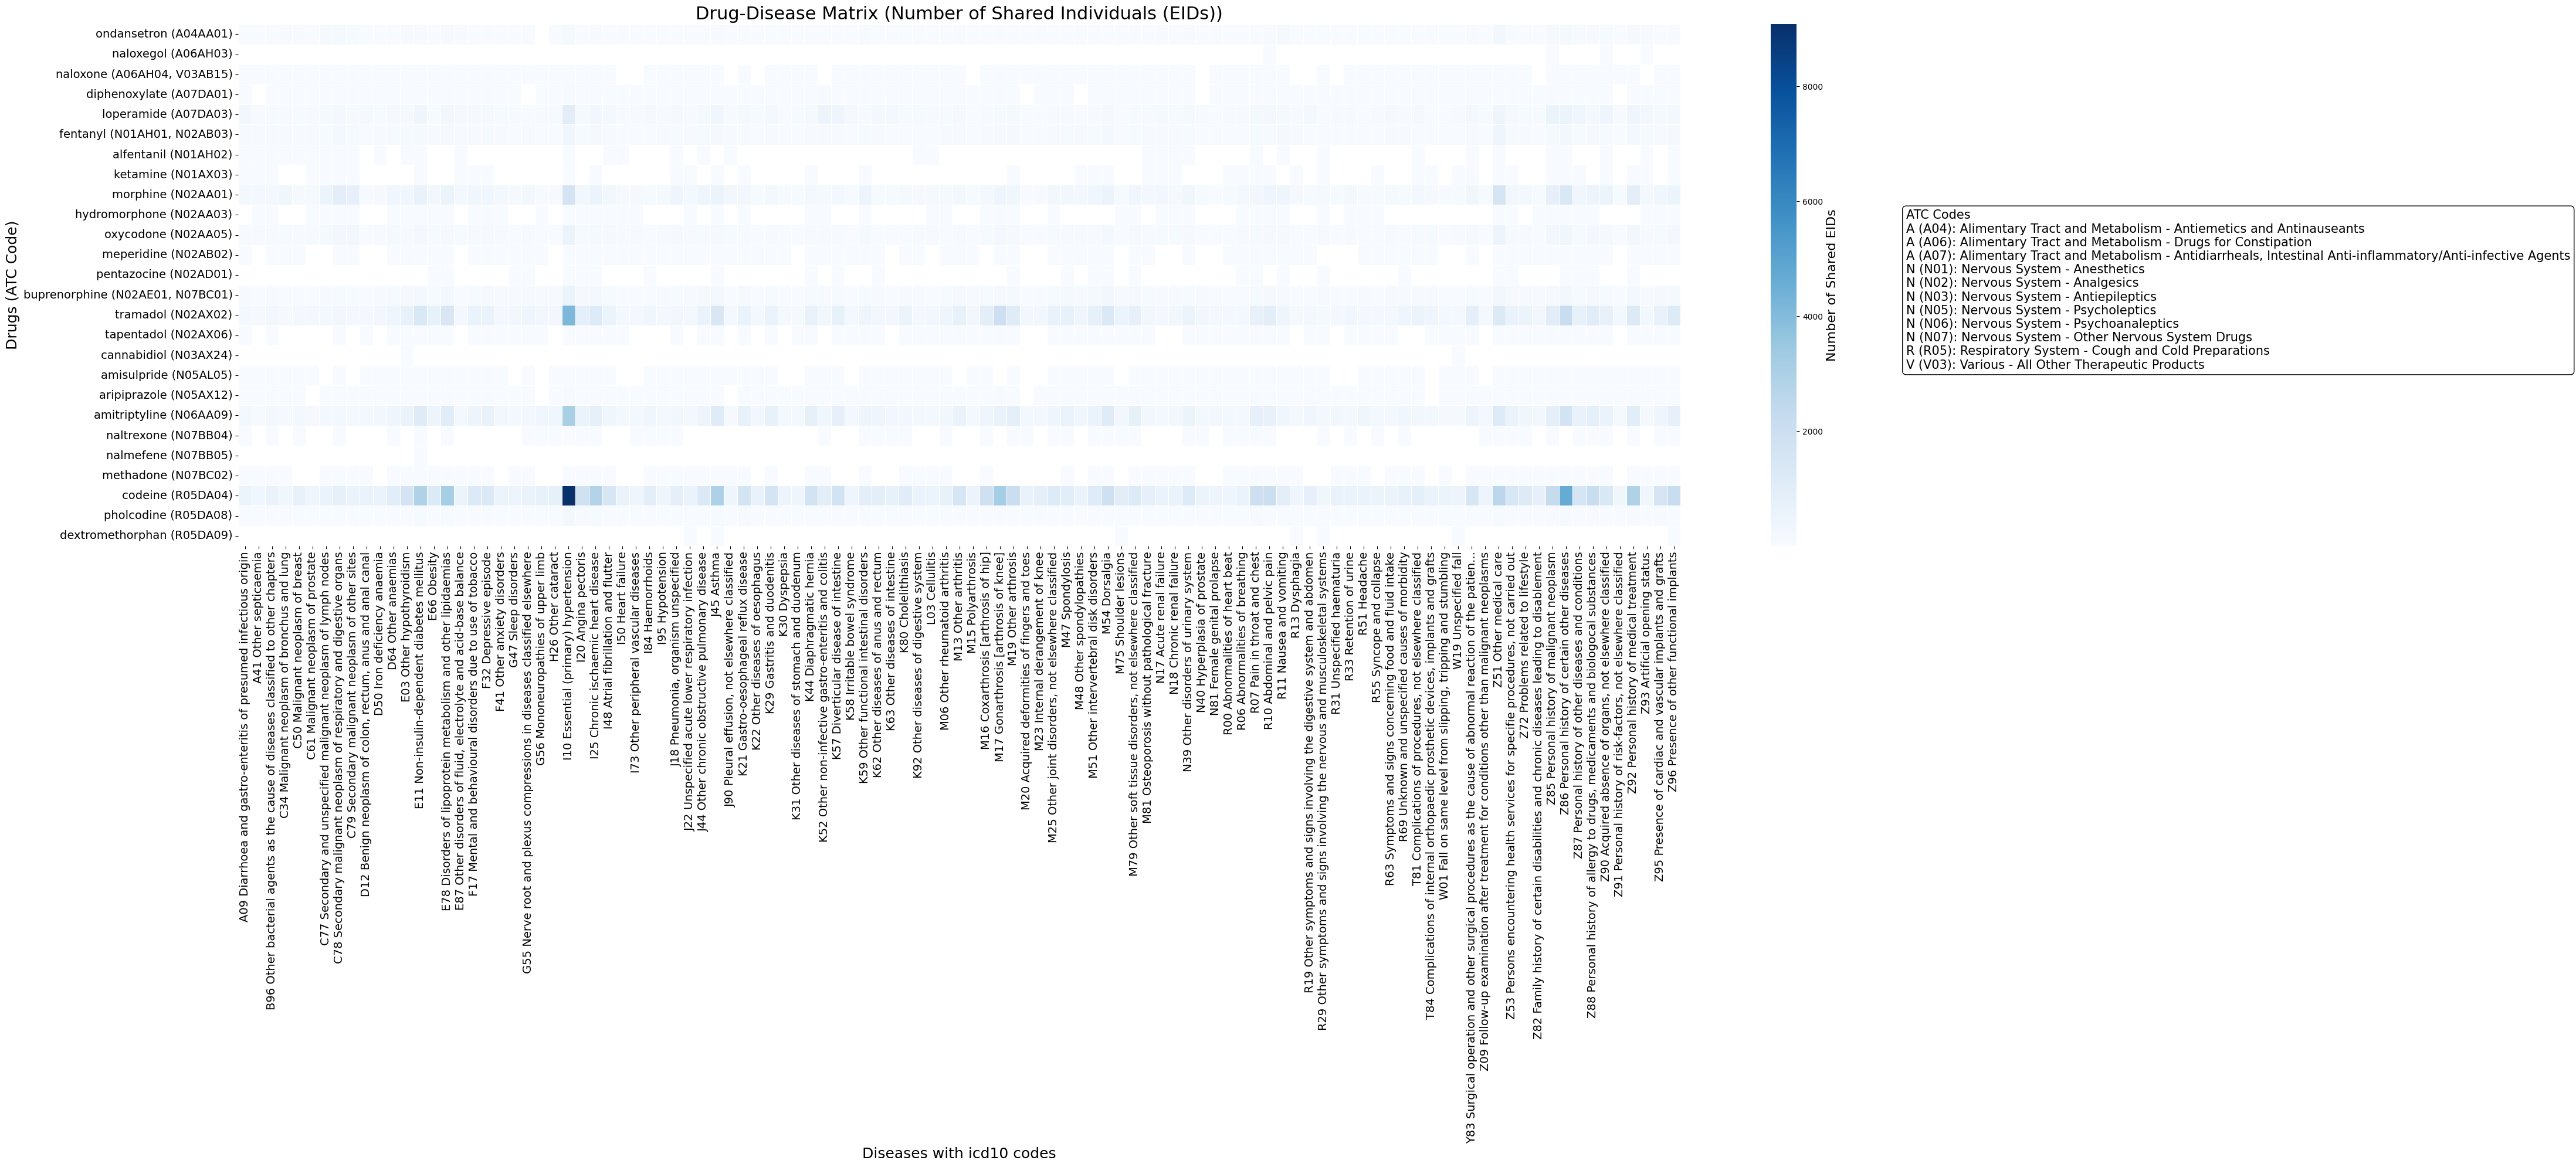

In [ ]:
# Plot the heatmap
plt.figure(figsize=(35, 20))
# Create a mask for zero values
mask = matrix == 0
# Plot the heatmap
plt.figure(figsize=(35, 20))
ax = sns.heatmap(
    matrix,
    annot=False,
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={"label": "Number of Shared EIDs"},
    mask=mask,
)  # Apply mask
# Customize labels
plt.xlabel(
    "Diseases with icd10 codes", fontsize=18
)  # Set larger font size for x-axis label
plt.ylabel("Drugs (ATC Code)", fontsize=18)  # Set larger font size for y-axis label
plt.title(
    "Drug-Disease Matrix (Number of Shared Individuals (EIDs))", fontsize=22
)  # Set larger font size for the title
plt.xticks(rotation=90, fontsize=14)  # Rotate and set larger font size for x-axis ticks
plt.yticks(rotation=0, fontsize=14)

# Get the colorbar and set its label size
cbar = ax.collections[0].colorbar
cbar.set_label(
    "Number of Shared EIDs", fontsize=16
)  # Set larger font size for cbar label

# Create a legend for ATC codes
plt.figtext(
    0.93,
    0.75,
    "ATC Codes\n" + atc_legend_text,
    wrap=True,
    fontsize=15,
    verticalalignment="center",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("drug_disease_heatmap.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()